# Convolutional Neural Network Model for Land Classification

In [76]:
# Suppress warnings from libraries to keep the output clean
import warnings
warnings.filterwarnings('ignore')

# Import standard Python libraries
import os  # For operating system dependent functionality
import shutil  # For file operations like copying and removing files
import itertools  # For advanced iteration operations
import random  # For generating random numbers

# Import scientific computing libraries
import pandas as pd  # For data manipulation and analysis
import numpy as np  # For numerical operations

# Import libraries for plotting and visualization
import matplotlib.pyplot as plt  # For creating static, animated, and interactive visualizations

# Import TensorFlow, a deep learning library
import tensorflow as tf

# Import Keras, a high-level API for building and training deep learning models
import tensorflow.keras
from keras import models
from tensorflow.keras import backend as K  # For accessing the Keras backend
from tensorflow.keras.applications import imagenet_utils  # Utilities for ImageNet data
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # For real-time data augmentation
from tensorflow.keras.preprocessing import image  # For image preprocessing utilities
from tensorflow.keras.metrics import categorical_crossentropy  # Loss function for multi-class classification
from tensorflow.keras.optimizers import Adam  # Optimizer for training models
from tensorflow.keras.models import Sequential, Model, load_model  # For creating and loading models

# Import various Keras layers for building neural networks
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D
from tensorflow.keras.layers import Activation, Dense, Flatten, Input

# Import scikit-learn and SciPy libraries
from sklearn.metrics import confusion_matrix  # For computing confusion matrix
from scipy import misc, ndimage  # For image processing

# Enable inline plotting in Jupyter notebooks
%matplotlib inline

In [77]:
# Restore np.random.seed to its original state
np.random.seed = np.random.seed

# Ensure np.random.seed is not reassigned
assert isinstance(np.random.seed, type(np.random.RandomState().seed)), "np.random.seed has been reassigned."

# Set up a reproducible environment
# Setting a specific hash seed for Python's hash-based operations
os.environ['PYTHONHASHSEED'] = '0'
# Setting the seed for NumPy's random number generator
np.random.seed(123)
# Setting the seed for Python's random module
random.seed(456)
# Setting the seed for TensorFlow's random number generator
tf.random.set_seed(789)

# Configure TensorFlow session to use a single thread for operations
tf.config.threading.set_intra_op_parallelism_threads(1)
tf.config.threading.set_inter_op_parallelism_threads(1)

In [78]:
# Set the path to the main dataset and the path to the train, valid and test folders within the dataset_splits folder
base_path = 'C:/Users/isaac/datasets/eurosat-dataset'
train_path = os.path.join(base_path, 'dataset_splits/train')
valid_path = os.path.join(base_path, 'dataset_splits/valid')
test_path = os.path.join(base_path, 'dataset_splits/test')

In [79]:
# Initialize an empty list to store category names
categories = []

# Walk through the directory tree starting from the specified path
for dirpath, dirnames, filenames in os.walk(base_path):
    # Filter out 'dataset_splits' directory from the list of dirnames
    # This will modify dirnames in-place and prevent os.walk from visiting this directory
    dirnames[:] = [d for d in dirnames if d != 'dataset_splits']
    
    # Add the remaining directory names (categories) to the categories list
    categories.extend(dirnames)

# Print the list of categories (subdirectory names)
print(categories)

['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


In [80]:
for category in categories:
    tr = os.path.join(train_path, category)
    len_tr = len(os.listdir(tr))
    
    val = os.path.join(valid_path, category)
    len_val = len(os.listdir(val))
    
    test = os.path.join(test_path, category)
    len_test = len(os.listdir(val))

    print(category + ":")
    print('Train images for ' + category + ': {}'.format(len_tr))
    print('Validation images for ' + category + ': {}'.format(len_val))
    print('Test images for ' + category + ': {}'.format(len_test))
    print('')

AnnualCrop:
Train images for AnnualCrop: 1200
Validation images for AnnualCrop: 150
Test images for AnnualCrop: 150

Forest:
Train images for Forest: 1200
Validation images for Forest: 150
Test images for Forest: 150

HerbaceousVegetation:
Train images for HerbaceousVegetation: 1200
Validation images for HerbaceousVegetation: 150
Test images for HerbaceousVegetation: 150

Highway:
Train images for Highway: 1000
Validation images for Highway: 125
Test images for Highway: 125

Industrial:
Train images for Industrial: 1000
Validation images for Industrial: 125
Test images for Industrial: 125

Pasture:
Train images for Pasture: 800
Validation images for Pasture: 100
Test images for Pasture: 100

PermanentCrop:
Train images for PermanentCrop: 1000
Validation images for PermanentCrop: 125
Test images for PermanentCrop: 125

Residential:
Train images for Residential: 1200
Validation images for Residential: 150
Test images for Residential: 150

River:
Train images for River: 1000
Validation im

In [81]:
train_batches = ImageDataGenerator().flow_from_directory(train_path,
                                                         target_size=(64, 64),
                                                         classes=categories,
                                                         batch_size=20)
valid_batches = ImageDataGenerator().flow_from_directory(valid_path,
                                                         target_size=(64, 64),
                                                         classes=categories,
                                                         batch_size=10)
test_batches = ImageDataGenerator().flow_from_directory(test_path,
                                                         target_size=(64, 64),
                                                         classes=categories,
                                                         batch_size=10,
                                                         shuffle=False)

Found 10800 images belonging to 10 classes.
Found 1350 images belonging to 10 classes.
Found 1350 images belonging to 10 classes.


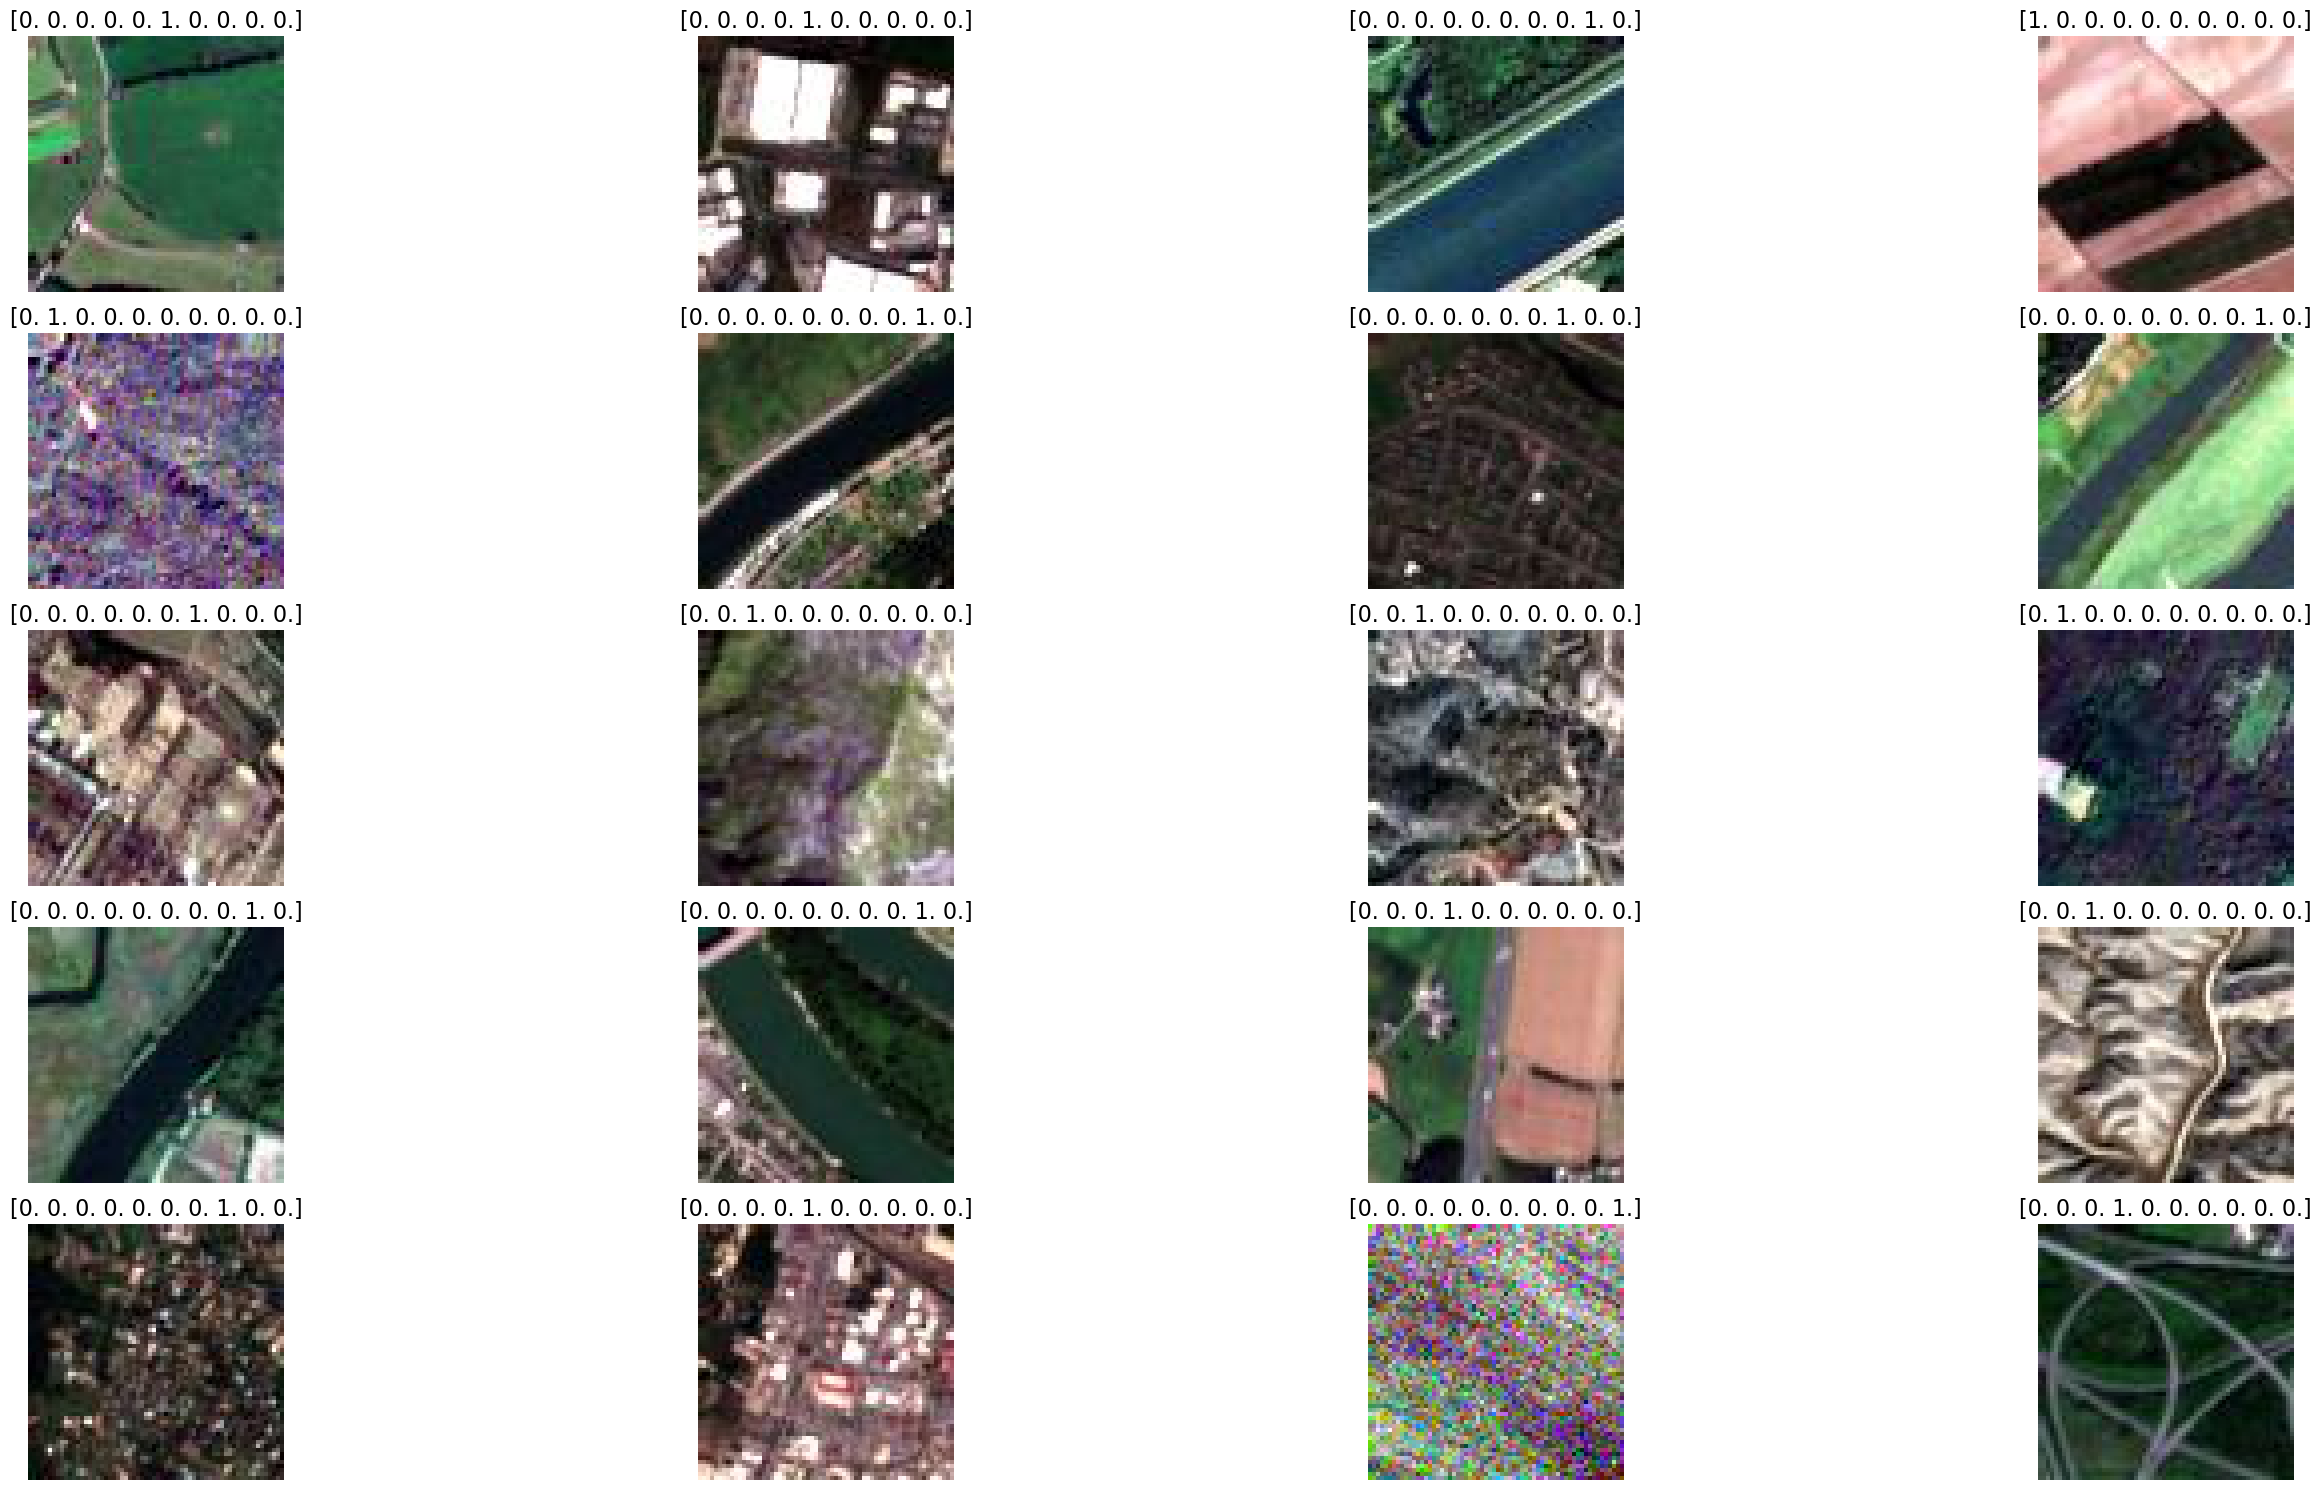

In [82]:
# Function to plot images with labels within a Jupyter notebook
# Adapted from GitHub/YouTube user deeplizard
def plots(ims, figsize=(30, 15), rows=1, interp=False, titles=None):
    # Check if the input is a list of numpy arrays
    if isinstance(ims[0], np.ndarray):
        # Convert to uint8 type for image display
        ims = np.array(ims).astype(np.uint8)
        # Ensure the images have the correct shape for display
        if ims.shape[-1] != 3:  # Check if the last dimension is not 3 (RGB channels)
            ims = ims.transpose((0, 2, 3, 1))  # Rearrange dimensions to (N, H, W, C)

    # Create a new figure with the specified size
    f, axes = plt.subplots(rows, len(ims) // rows + (len(ims) % rows != 0), figsize=figsize)
    
    # Flatten axes array if there are multiple rows
    if rows > 1:
        axes = axes.flatten()
    else:
        axes = [axes]
    
    # Iterate through images and plot them
    for i, ax in enumerate(axes):
        if i < len(ims):
            ax.axis('Off')
            if titles is not None and i < len(titles):
                ax.set_title(titles[i], fontsize=16)
            ax.imshow(ims[i], interpolation='none' if not interp else 'bilinear')
        else:
            ax.axis('Off')  # Hide any extra subplots
    
    plt.tight_layout()
    plt.show()

# Example usage with a batch of images and labels
imgs, labels = next(train_batches)
plots(imgs, rows=5, titles=labels)

# CNN Training and Building

In [83]:
# Define the model using Sequential API
model = Sequential([
    Input(shape=(64, 64, 3)),  # Define input shape explicitly
    Conv2D(32, (3, 3), activation='relu'),  # Convolutional layer
    Flatten(),  # Flatten into 1-D tensor
    Dense(10, activation='softmax')  # Output layer that categorizes images
])

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [84]:
%%time
# fits the model on data generated batch by batch by ImageDataGenerator
model.fit(train_batches, steps_per_epoch=1080,
          validation_data=valid_batches, validation_steps=270,
          epochs=5,
          verbose=2)

Epoch 1/5
1080/1080 - 10s - 9ms/step - accuracy: 0.3702 - loss: 35.8697 - val_accuracy: 0.4548 - val_loss: 10.0711
Epoch 2/5
1080/1080 - 8s - 8ms/step - accuracy: 0.6565 - loss: 3.8346 - val_accuracy: 0.4681 - val_loss: 6.8028
Epoch 3/5
1080/1080 - 9s - 8ms/step - accuracy: 0.8217 - loss: 1.0607 - val_accuracy: 0.5022 - val_loss: 5.6439
Epoch 4/5
1080/1080 - 9s - 8ms/step - accuracy: 0.9139 - loss: 0.3857 - val_accuracy: 0.5215 - val_loss: 5.1996
Epoch 5/5
1080/1080 - 9s - 8ms/step - accuracy: 0.9441 - loss: 0.2432 - val_accuracy: 0.5341 - val_loss: 5.4157
CPU times: total: 8.61 s
Wall time: 45.2 s


# Prediction On Test Set

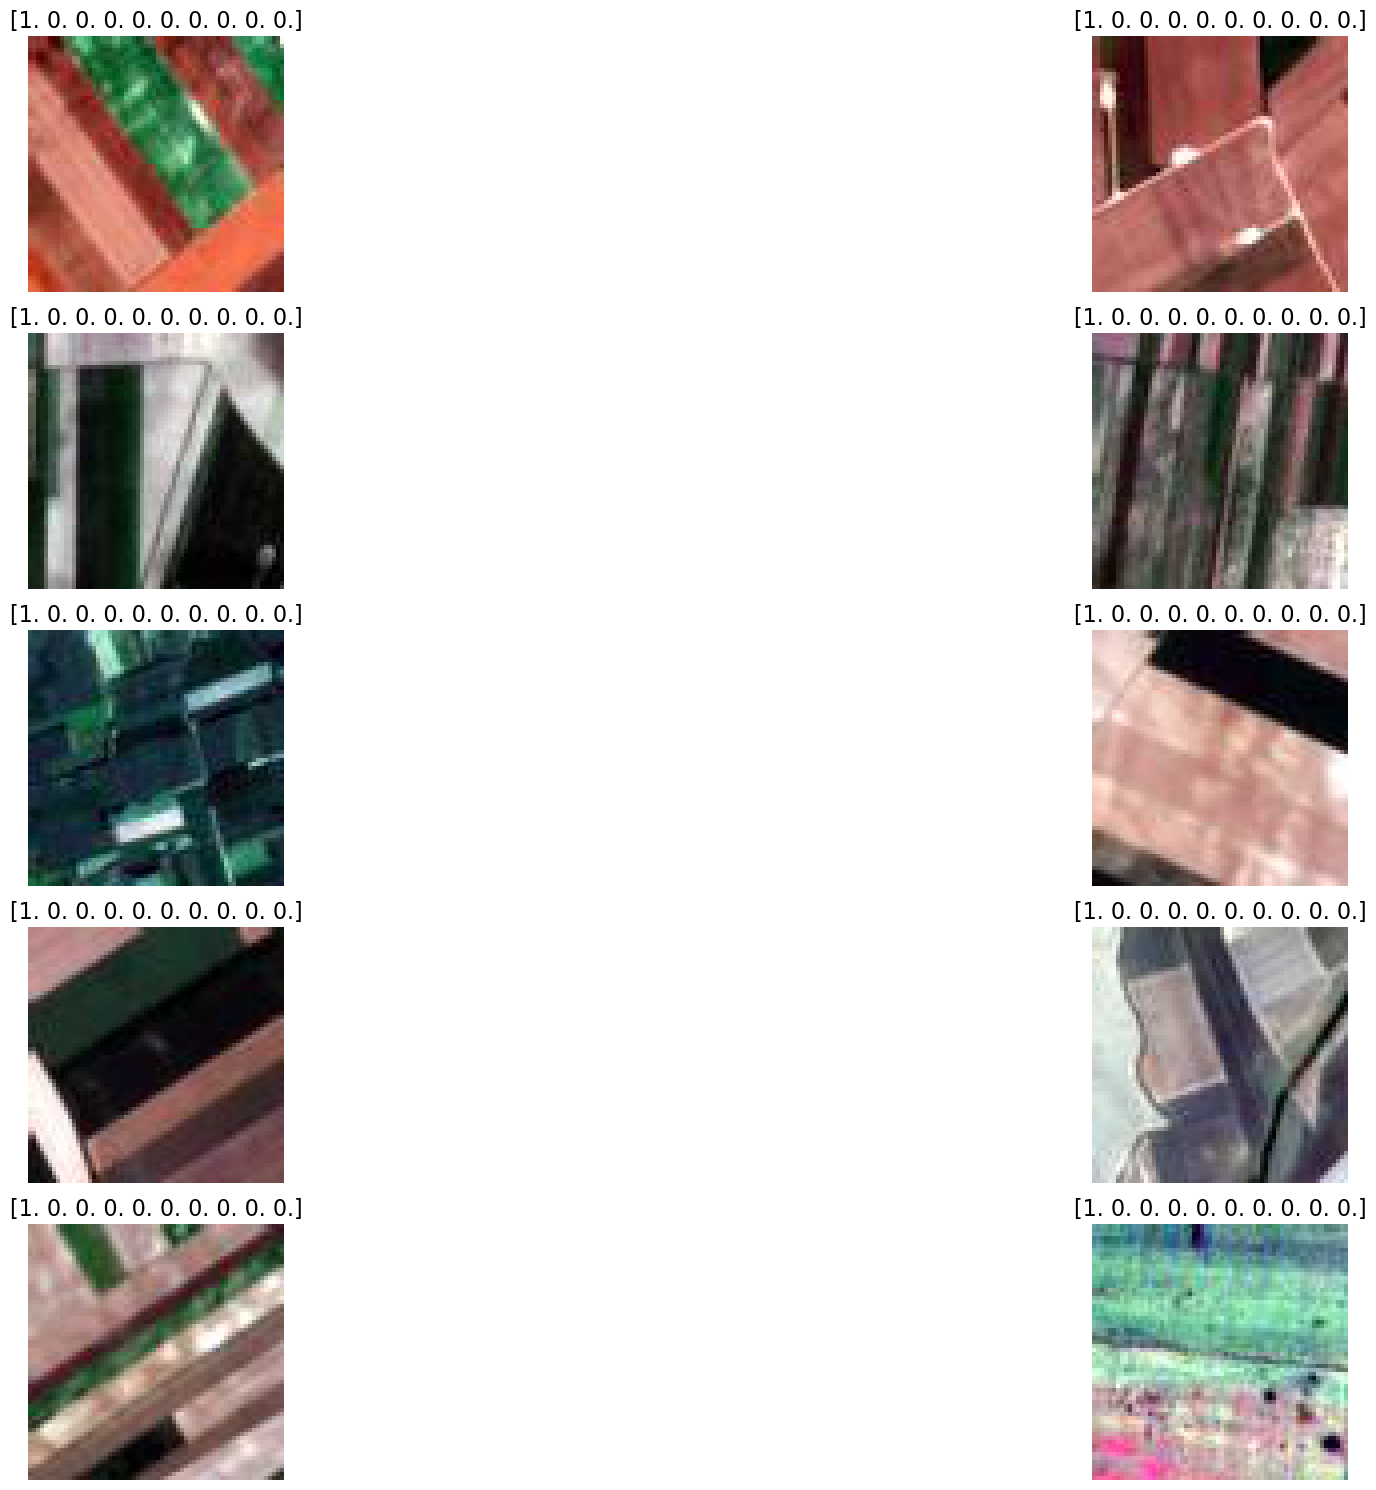

In [85]:
test_imgs, test_labels = next(test_batches)
plots(test_imgs, rows=5, titles=test_labels)

In [86]:
test_labels = test_batches.classes
test_labels

array([0, 0, 0, ..., 9, 9, 9])

In [87]:
# get the assigned class labels
test_batches.class_indices

{'AnnualCrop': 0,
 'Forest': 1,
 'HerbaceousVegetation': 2,
 'Highway': 3,
 'Industrial': 4,
 'Pasture': 5,
 'PermanentCrop': 6,
 'Residential': 7,
 'River': 8,
 'SeaLake': 9}

In [88]:
# Generate predictions on the test dataset using the model and the test_batches generator.
# `steps=270` indicates the number of batches to yield from the generator before stopping.
# `verbose=0` suppresses the progress messages.
predictions = model.predict(test_batches, steps=270, verbose=0)

# Calculate the confusion matrix to evaluate the accuracy of the classification.
# `test_labels` are the true labels of the test data.
# `predictions.argmax(axis=1)` finds the class with the highest predicted probability for each sample.
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

In [89]:
# modified from scikit-learn.org
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(15, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes
              )
    if normalize:
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i,j],
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

Confusion matrix, without normalization
[[ 85   4  11   7   5   7  11   1  11   8]
 [  1  90  14   1   0  10   2  13   4  15]
 [ 14   6  76   9   8   1  13  12   8   3]
 [  5   5   8  53   6   8  14  14   9   3]
 [  1   0   7   2  66   0  15  31   3   0]
 [ 10  11  12   3   0  43   5   0  11   5]
 [ 13   2  32   8  10   6  37   9   6   2]
 [  0   2  12   4  13   2   7 105   5   0]
 [ 13   3   6  21   6   9   3  10  47   7]
 [ 11   9   2   1   0   4   2   2   5 114]]


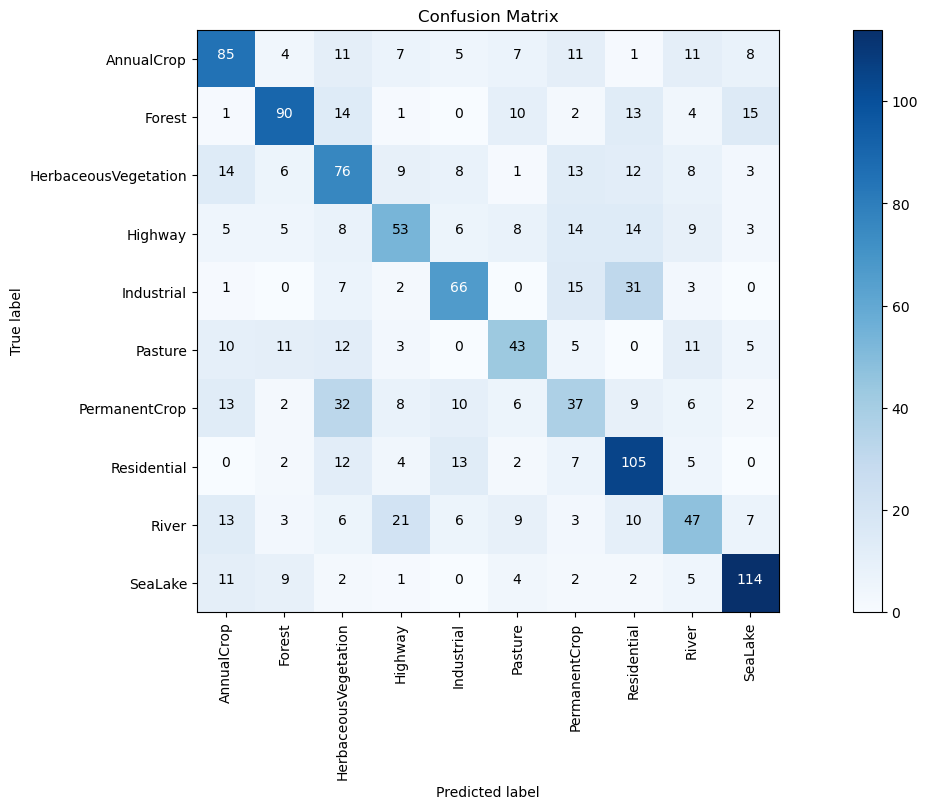

In [90]:
plot_confusion_matrix(cm, categories, title='Confusion Matrix')

In [91]:
vgg16_model = tensorflow.keras.applications.vgg16.VGG16(include_top=False, input_shape=(64,64,3))

In [92]:
vgg16_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [93]:
# VGG16 model is type Model from the keras functional API
type(vgg16_model)

keras.src.models.functional.Functional

In [94]:
model = Sequential()
for layer in vgg16_model.layers:
    model.add(layer)

# this sequential model is now the same architecture as the VGG16 model
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ block1_conv1 (Conv2D)           │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [95]:
# train a certain number of layers to learn about the type of data we're using,
# which is much different than for imagenet
NUM_TRAINABLE_LAYERS = 10
for layer in model.layers[:-NUM_TRAINABLE_LAYERS]:
    layer.trainable = False #excludes layer from future training so weights will not be updated when we train the model on our own data

In [96]:
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(len(categories), activation='softmax'))

model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ block1_conv1 (Conv2D)           │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,031,562 (61.16 MB)

 Trainable params: 14,886,154 (56.79 MB)

 Non-trainable params: 1,145,408 (4.37 MB)

### Training the transfer CNN model

In [97]:
# Define the optimizer with the desired learning rate
optimizer = Adam(learning_rate=0.0001)

# Compile the model using the defined optimizer
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [98]:
%%time
history = model.fit(train_batches, steps_per_epoch=1080,
                   validation_data=valid_batches, validation_steps=270,
                   epochs=10,
                   verbose=2)

Epoch 1/10
1080/1080 - 568s - 526ms/step - accuracy: 0.7996 - loss: 0.6732 - val_accuracy: 0.7570 - val_loss: 0.9070
Epoch 2/10
1080/1080 - 556s - 515ms/step - accuracy: 0.9109 - loss: 0.2950 - val_accuracy: 0.8800 - val_loss: 0.3850
Epoch 3/10
1080/1080 - 922s - 853ms/step - accuracy: 0.9373 - loss: 0.2062 - val_accuracy: 0.9296 - val_loss: 0.2625
Epoch 4/10
1080/1080 - 642s - 594ms/step - accuracy: 0.9492 - loss: 0.1687 - val_accuracy: 0.9363 - val_loss: 0.2054
Epoch 5/10
1080/1080 - 625s - 579ms/step - accuracy: 0.9618 - loss: 0.1270 - val_accuracy: 0.9141 - val_loss: 0.2937
Epoch 6/10
1080/1080 - 597s - 552ms/step - accuracy: 0.9629 - loss: 0.1262 - val_accuracy: 0.9126 - val_loss: 0.4096
Epoch 7/10
1080/1080 - 585s - 542ms/step - accuracy: 0.9668 - loss: 0.1125 - val_accuracy: 0.8533 - val_loss: 0.7455
Epoch 8/10
1080/1080 - 559s - 518ms/step - accuracy: 0.9744 - loss: 0.0843 - val_accuracy: 0.9415 - val_loss: 0.2406
Epoch 9/10
1080/1080 - 601s - 557ms/step - accuracy: 0.9744 - lo

In [100]:
test_labels = test_batches.classes
test_labels

array([0, 0, 0, ..., 9, 9, 9])

In [101]:
test_batches.class_indices

{'AnnualCrop': 0,
 'Forest': 1,
 'HerbaceousVegetation': 2,
 'Highway': 3,
 'Industrial': 4,
 'Pasture': 5,
 'PermanentCrop': 6,
 'Residential': 7,
 'River': 8,
 'SeaLake': 9}

In [102]:
# Make predictions on the test data using the model
predictions = model.predict(test_batches, steps=270, verbose=0)

Confusion matrix, without normalization
[[125   0   1   0   1   7  11   0   4   1]
 [  0 129   7   0   0   2   0  12   0   0]
 [  0   0 136   0   0   5   5   4   0   0]
 [  3   1   1 112   1   1   1   0   5   0]
 [  0   0   1   0 120   0   1   3   0   0]
 [  0   0   1   0   0  98   0   0   1   0]
 [  3   0   9   0   1   0 111   1   0   0]
 [  0   0   0   1   2   0   0 147   0   0]
 [  0   0   1   2   0   0   0   0 122   0]
 [  0   0   3   0   0   1   0   1   2 143]]


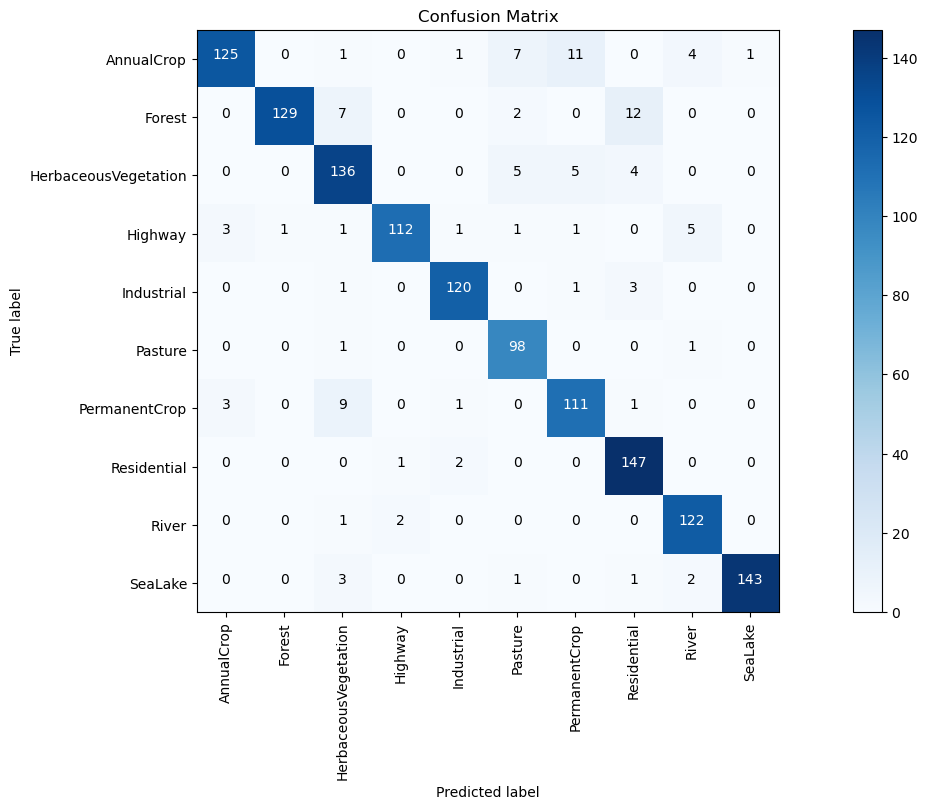

In [103]:
# confusion matrix using the results of the model on the test set
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))
plot_confusion_matrix(cm, categories, title='Confusion Matrix')

In [104]:
# save trained model, including weights
model.save('land_use_model.keras')

# Viewing the Model Loss and Accuracy

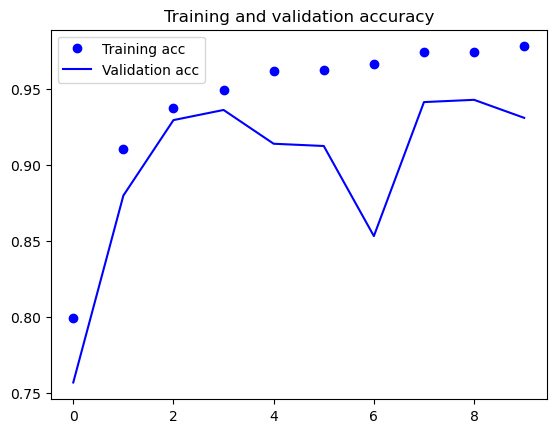

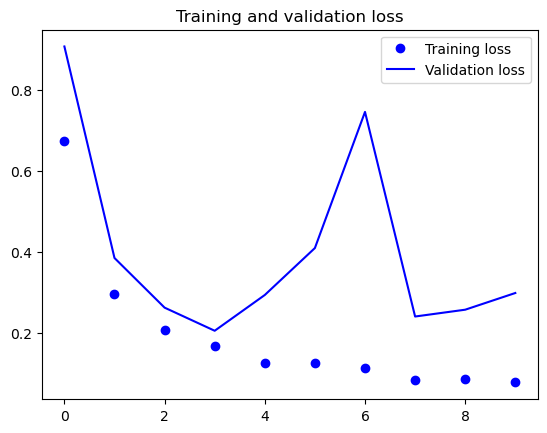

In [105]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Images at Intermediate Layers

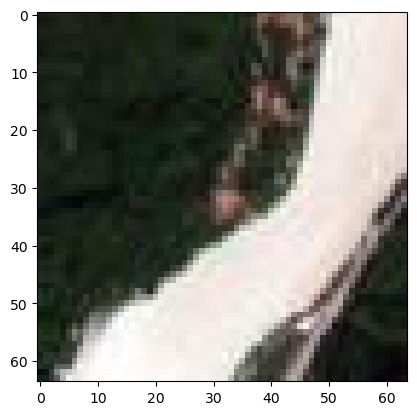

(1, 64, 64, 3)


In [106]:
# Load and preprocess the image
img_path =  test_path + '/River/River_26.jpeg'
img = image.load_img(img_path, target_size=(64, 64))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

# Visualize the image if needed
plt.imshow(img_tensor[0])
plt.show()

# Ensure the shape matches the model's input requirements
print(img_tensor.shape) 

In [107]:
# Use the same img_tensor for prediction
predictions = model.predict(img_tensor, batch_size=10)
predicted_class = np.argmax(predictions, axis=1)

print("Predicted class is:", predicted_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
Predicted class is: [1]


In [1]:
# Load and preprocess the image
img_path = "C:/Users/isaac/Desktop/MelliehaCut.jpg"
img = image.load_img(img_path, target_size=(64, 64))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

# Visualize the image if needed
plt.imshow(img_tensor[0])
plt.show()

# Ensure the shape matches the model's input requirements
print(img_tensor.shape) 

NameError: name 'image' is not defined

In [113]:
# Use the same img_tensor for prediction
predictions = model.predict(img_tensor, batch_size=10)
predicted_class = np.argmax(predictions, axis=1)

print("Predicted class is:", predicted_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Predicted class is: [1]


In [110]:
layer_outputs = [layer.get_output_at(-1) for layer in model.layers[:10]] # Extracts the outputs of the top 12 layers
activation_model = models.Model(inputs=model.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input

AttributeError: 'Conv2D' object has no attribute 'get_output_at'

In [111]:
activations = activation_model.predict(img_tensor)

NameError: name 'activation_model' is not defined

In [112]:
layer_names = []
for layer in model.layers[:10]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

NameError: name 'activations' is not defined